# Chapter 3 word2vec 

통계 기반 기법은 주변 단어의 빈도를 기초로 단어를 표현했습니다. 단어의 동시행렬을 만들고 그 행렬에 SVD를 활용하여 밀집벡터를 얻었습니다. 그러나 이 방식은 대규모 말뭉치를 다룰 때 문제가 발생합니다. 계산을 하는데 시간이 많이 걸려 현실적이지 않습니다. 

한편 추론 기반 기법에서는 신경망을 이용하는 경우는 미니배치로 학습하는 것이 일반적입니다. 신경망이 한 번에 소량의 학습 샘플씩 반복해서 학습하여 가중치를 갱신해값니다. (통계 기법과 다른 점은 미니배치는 데이터의 일부를 활용하여 순차적으로 학습합니다.) 

추론 과정에서 신경망을 이용해 단어를 처리합니다. 그런데 단어 그 자체를 사용 할 수 없으니 고정 길이의 벡터로 변환해야 합니다. 이때 사용하는 대표적인 방법은 one-hot encoder입니다. 벡터의 원소 중 하나만 1이고 나머지는 모두 0인 벡터를 말합니다. 

단어를 고정 길이 벡터로 변환하면 신경망의 입력충의 뉴런의 수를 고정할 수 있습니다. 이 때 신경망은 완전연결계층이므로 각각의 노드가 이웃 층의 모든 노드와 화살표로 연결되어 있습니다. 이 신경망의 과정에서는 가중치가 존재하여, 입력층 뉴럭과의 가중합이 은닉층 뉴럭이 됩니다. 

In [2]:
## 과정 계산 
import numpy as np 
c = np.array([[1,0,0,0,0,0,0]])
W = np.random.rand(7, 3) # 가중치 
h = np.matmul(c, W) # 중간 노드 
print(h)

[[0.99101355 0.32678703 0.0948381 ]]


c와 W의 행렬 곱을 보면 c는 원핫 표현이므로 단어 ID에 대응하는 원소만 1이고 그 외에는 0인 벡터입니다. 따라서 앞 코드의 c와 w의 행렬곱은 결국 가중치의 행벡터 하나를 뽑아 낸 것입니다. 

In [6]:
import sys 
sys.path.append('..')
import numpy as np 
from common.layers import MatMul

c = np.array([[1,0,0,0,0,0,0]])
W = np.random.rand(7, 3) # 가중치 
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[0.98249088 0.23209889 0.50703919]]


word2vec은 CBOW (Continuous bag-of-words)라는 신경망 모델을 제안합니다. CBOW 모델은 맥락으로부터 타깃을 추측하는 용도의 신경망입니다. 주위 단어를 활용을 해 해당 단어를 추론합니다.

CBOW 모델을 활용할 시 가장 먼저 맥락 (단어들을) 원핫 표현으로 변환하여 모델이 처리할 수 있도록 준비합니다.

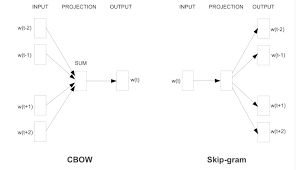

입력층이 다수가 있고, 은닉층을 거쳐 출력층에 도달합니다. 두 입력층에서 은닉충으로의 변환은 똑같은 완전연결계층이 처리합니다. 그리고 은닉층에서 출력층 뉴런의 변환은 다른 완전연결계층이 처리합니다.

은닉층의 뉴런은 입력의 완전연결계층에 의해 변환된 값이 되는데 입력층이 여러개이면 전체를 평균한면 됩니다. 그리고 마지막 출력층에는 각 원소들의 점수를 출력합니다. 그리고 이 점수들을 소프트맥스 함수를 사용하여 확률을 얻을 수 있습니다. 

계층 관전에서 보면 CBOW모델 가장 앞에는 2개의 MatMul계층이 있고 이 계층을 더한뒤 평균을 냅니다. 그럼 평균이 은닉층 뉴런이 됩니다. 마지막으로 은닉충 뉴런에 또 다른 Matmul 계층이 적용되어 점수가 출력됩니다. 


In [7]:
# coding: utf-8
# 2개의 입력층 
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul


# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)

[[-1.59778458 -0.21873148 -1.91193193  1.51603945  0.72302117  1.28438962
   2.1005063 ]]


CBOW 모델의 학습 
CBOW 모델은 출력층에서 각 단어의 점수를 출력했습니다. 이 점수에 스프트맥스 함수를 적용하면 확률을 얻을 수 있습니다. 이때 가중치가 적절히 설정 신경망이라면 확률을 나타내는 뉴런들 중 정답에 해당하는 뉴런의 값이 클 것이라 기대할 수 있습니다. 

CBOW도델에서의 학습은 올바른 예측을 할 수 있도록 가중치를 조정하는 일을 합니다. 그 결과로 가중치에 단어의 출현 패턴을 파악한 벡터가 학습됩니다. 소프트맥스와 교차 엔트로피 오차를 활용하여 학습을 진행합니다. 

word2vec의 가중치와 분산 표현 
지금까지 설명으로는 word2vec에서는 사용되는 신경망에는 두 가지 가중치가 있습니다. 바로 입력 층 완전연결계층의 가중치와 출력 측 완전연결계층의 가중치입니다. 그리고 입력 측 가중치의 각 행이 각 단어의 분산 표현에 해당합니다. 출력 층 가중치에도 단어의 의미가 인코딩된 벡터가 저장되고 있다고 생각할 수 있습니다. 다만 출력측 가중치는 각 단어의 분산 표현이 열 방향으로 저장됩니다. 

단어의 분산 표현으로는 입력측의 가중치, 출력측 가중치, 양쪽 가중치를 이용할 수 있습니다. word2vec(skip-gram)에서는 입력층의 가중치만 이용한다가 가장 대중적인 방법입니다. 

In [8]:
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [14]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus) - window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue 
            cs.append(corpus[idx+t])
        contexts.append(cs)
    return np.array(contexts), np.array(target)

In [15]:
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [16]:
## one hot encoder 
from common.util import preprocess, create_contexts_target, convert_one_hot
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
contexts, target = create_contexts_target(corpus, window_size=1)
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [19]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 410 |  반복 1 / 2 | 시간 0[s] | 손실 0.94
| 에폭 411 |  반복 1 / 2 | 시간 0[s] | 손실 0.69
| 에폭 412 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 413 |  반복 1 / 2 | 시간 0[s] | 손실 0.80
| 에폭 414 |  반복 1 / 2 | 시간 0[s] | 손실 0.76
| 에폭 415 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 416 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 417 |  반복 1 / 2 | 시간 0[s] | 손실 0.77
| 에폭 418 |  반복 1 / 2 | 시간 0[s] | 손실 0.84
| 에폭 419 |  반복 1 / 2 | 시간 0[s] | 손실 0.77
| 에폭 420 |  반복 1 / 2 | 시간 0[s] | 손실 0.73
| 에폭 421 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 422 |  반복 1 / 2 | 시간 0[s] | 손실 0.77
| 에폭 423 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 424 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 425 |  반복 1 / 2 | 시간 0[s] | 손실 0.76
| 에폭 426 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 427 |  반복 1 / 2 | 시간 0[s] | 손실 0.83
| 에폭 428 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 429 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 430 |  반복 1 / 2 | 시간 0[s] | 손실 0.72
| 에폭 431 |  반복 1 / 2 | 시간 0[s] | 손실 0.91
| 에폭 432 |  반복 1 / 2 | 시간 0[s] | 손실 0.73
| 에폭 433 |  반복 1 / 2 | 시간 0[s] | 손실 0.71
| 에폭 434 |  반복 1

| 에폭 633 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 634 |  반복 1 / 2 | 시간 0[s] | 손실 0.70
| 에폭 635 |  반복 1 / 2 | 시간 0[s] | 손실 0.34
| 에폭 636 |  반복 1 / 2 | 시간 0[s] | 손실 0.66
| 에폭 637 |  반복 1 / 2 | 시간 0[s] | 손실 0.36
| 에폭 638 |  반복 1 / 2 | 시간 0[s] | 손실 0.69
| 에폭 639 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 640 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 641 |  반복 1 / 2 | 시간 0[s] | 손실 0.45
| 에폭 642 |  반복 1 / 2 | 시간 0[s] | 손실 0.55
| 에폭 643 |  반복 1 / 2 | 시간 0[s] | 손실 0.45
| 에폭 644 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 645 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 646 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 647 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 648 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 649 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 650 |  반복 1 / 2 | 시간 0[s] | 손실 0.43
| 에폭 651 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 652 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 653 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 654 |  반복 1 / 2 | 시간 0[s] | 손실 0.62
| 에폭 655 |  반복 1 / 2 | 시간 0[s] | 손실 0.42
| 에폭 656 |  반복 1 / 2 | 시간 0[s] | 손실 0.42
| 에폭 657 |  반복 1

| 에폭 849 |  반복 1 / 2 | 시간 0[s] | 손실 0.40
| 에폭 850 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 851 |  반복 1 / 2 | 시간 0[s] | 손실 0.29
| 에폭 852 |  반복 1 / 2 | 시간 0[s] | 손실 0.32
| 에폭 853 |  반복 1 / 2 | 시간 0[s] | 손실 0.50
| 에폭 854 |  반복 1 / 2 | 시간 0[s] | 손실 0.26
| 에폭 855 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 856 |  반복 1 / 2 | 시간 0[s] | 손실 0.36
| 에폭 857 |  반복 1 / 2 | 시간 0[s] | 손실 0.42
| 에폭 858 |  반복 1 / 2 | 시간 0[s] | 손실 0.39
| 에폭 859 |  반복 1 / 2 | 시간 0[s] | 손실 0.39
| 에폭 860 |  반복 1 / 2 | 시간 0[s] | 손실 0.46
| 에폭 861 |  반복 1 / 2 | 시간 0[s] | 손실 0.29
| 에폭 862 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 863 |  반복 1 / 2 | 시간 0[s] | 손실 0.26
| 에폭 864 |  반복 1 / 2 | 시간 0[s] | 손실 0.49
| 에폭 865 |  반복 1 / 2 | 시간 0[s] | 손실 0.39
| 에폭 866 |  반복 1 / 2 | 시간 0[s] | 손실 0.28
| 에폭 867 |  반복 1 / 2 | 시간 0[s] | 손실 0.39
| 에폭 868 |  반복 1 / 2 | 시간 0[s] | 손실 0.39
| 에폭 869 |  반복 1 / 2 | 시간 0[s] | 손실 0.42
| 에폭 870 |  반복 1 / 2 | 시간 0[s] | 손실 0.28
| 에폭 871 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 872 |  반복 1 / 2 | 시간 0[s] | 손실 0.25
| 에폭 873 |  반복 1

C:\Users\edd6d\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\edd6d\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\edd6d\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\edd6d\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


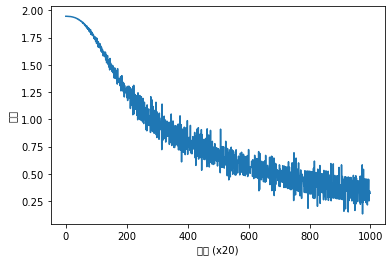

you [-0.83563673 -0.85814047 -0.8438607  -1.6561246  -1.0756186 ]
say [ 1.2000122   1.175549    1.213368   -0.32325494  1.094545  ]
goodbye [-1.1145699  -1.1306943  -1.0819076   0.40790746 -0.9468269 ]
and [ 0.6725437   0.6854041   0.59288025 -1.7734209   1.0824212 ]
i [-1.1044391 -1.1183431 -1.0788888  0.3999327 -0.9475239]
hello [-0.8389306  -0.85718435 -0.8513048  -1.6560156  -1.0779935 ]
. [1.302833   1.2530894  1.3215036  1.6025301  0.50361854]


In [21]:
import sys
sys.path.append('..')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.trainer import Trainer
from common.optimizer import Adam
#from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])